<a href="https://colab.research.google.com/github/vasisvaran/Deep-Learning-Papers-Reading-Roadmap/blob/master/week10/Assignment_4_Ex2_VGG16.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## MSDS458 Research Assignment 4:
### Submitted by: Vasu (Vasisvaran) Gopal

## Import packages 

In [45]:
import pandas as pd
import numpy as np

from matplotlib import pyplot as plt
from matplotlib import image as img
import matplotlib as mpl

from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelBinarizer

import os
import random
from PIL import Image
import sys
from tqdm.notebook import tqdm
from tensorflow.keras.utils import to_categorical
import tensorflow as tf
from tensorflow import keras
from keras import models, layers
from keras.models import Sequential
from keras.layers import Conv2D,MaxPooling2D,Activation, Dropout, Flatten, Dense
from keras.preprocessing.image import ImageDataGenerator
from packaging import version
import tensorflow.keras.backend as k
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns
from sklearn.manifold import TSNE
import matplotlib.patheffects as PathEffects
from sklearn.metrics import accuracy_score
from keras.optimizers import SGD
from sklearn.metrics import mean_squared_error as MSE
from keras.callbacks import ReduceLROnPlateau

## Verify TensorFlow Version and Keras Version

In [46]:
print("This notebook requires TensorFlow 2.0 or above")
print("TensorFlow version: ", tf.__version__)
assert version.parse(tf.__version__).release[0] >=2

This notebook requires TensorFlow 2.0 or above
TensorFlow version:  2.11.0


In [47]:
print("Keras version: ", keras.__version__)

Keras version:  2.11.0


## Mount Google Drive

In [48]:
from google.colab import drive
drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


## Download and extract dataset from Google Drive

In [49]:
!apt install unzip

# Prevent 
main_path = "/content/Human Action Recognition/Training_set.csv"

if os.path.exists(main_path)== False :
  !unzip -q "/content/gdrive/MyDrive/Temp/archive.zip"

Reading package lists... Done
Building dependency tree       
Reading state information... Done
unzip is already the newest version (6.0-25ubuntu1.1).
0 upgraded, 0 newly installed, 0 to remove and 22 not upgraded.


## Set random seeds

In [50]:
# Set a seed value
seed_value= 42

# 1. Set `PYTHONHASHSEED` environment variable at a fixed value
import os
os.environ['PYTHONHASHSEED']=str(seed_value)

# 2. Set `python` built-in pseudo-random generator at a fixed value
import random
random.seed(seed_value)

# 3. Set `numpy` pseudo-random generator at a fixed value
np.random.seed(seed_value)

# 4. Set `tensorflow` pseudo-random generator at a fixed value
tf.random.set_seed(seed_value)

## Loading HAR Dataset

In [51]:
# Reading the csv file into a dataframe

df = pd.read_csv('/content/Human Action Recognition/Training_set.csv')
df

,filename,label
0,Image_1.jpg,sitting
1,Image_2.jpg,using_laptop
2,Image_3.jpg,hugging
3,Image_4.jpg,sleeping
4,Image_5.jpg,using_laptop
...,...,...
12595,Image_12596.jpg,sitting
12596,Image_12597.jpg,clapping
12597,Image_12598.jpg,sitting
12598,Image_12599.jpg,dancing


## Exploratory Data Analysis (EDA)

In [52]:
# Checking the data types
df.dtypes

filename    object
label       object
dtype: object

In [53]:
# Checking for null values
df.isnull().sum()

filename    0
label       0
dtype: int64

/usr/local/lib/python3.8/dist-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


<AxesSubplot:xlabel='label', ylabel='count'>

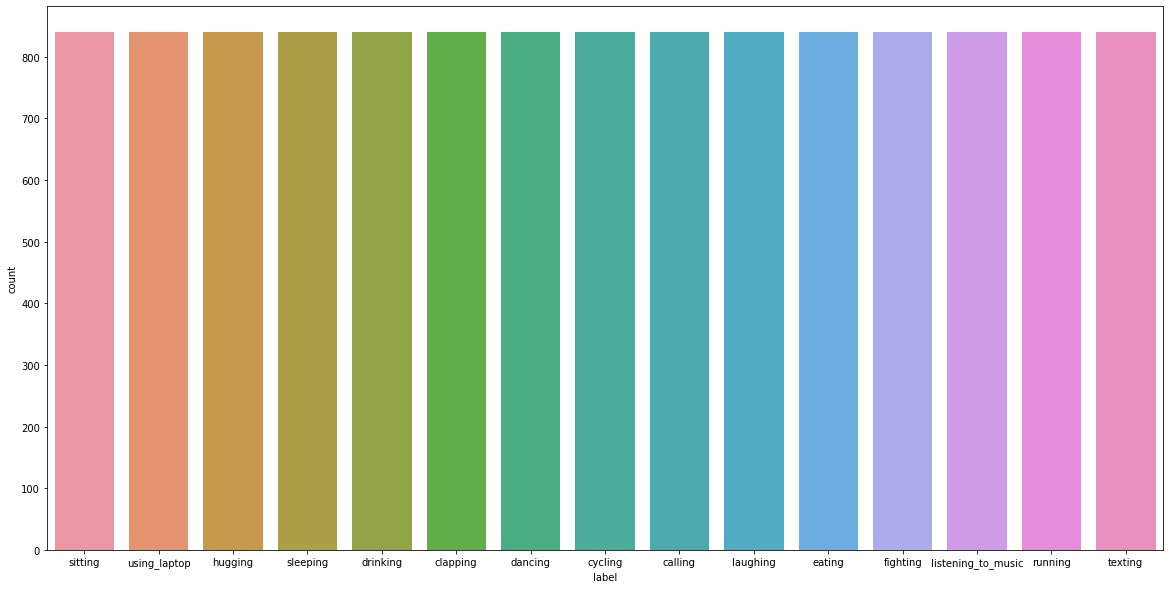

In [54]:
# Display label counts using seaborn count plot
plt.figure(figsize=(20,10))
sns.countplot(df['label'])

In [55]:
# Display value counts per class
counts = df['label'].value_counts()
print(counts)

sitting               840
using_laptop          840
hugging               840
sleeping              840
drinking              840
clapping              840
dancing               840
cycling               840
calling               840
laughing              840
eating                840
fighting              840
listening_to_music    840
running               840
texting               840
Name: label, dtype: int64


**Conclusion:** The dataset is balanced since it contains 15 classes and each class has 840 instances of images in the training dataset.

In [56]:
# Function to display few random images
def displayRandom(n=1):
    plt.figure(figsize=(20,20))
    for i in range(n):
        rnd = random.randint(0,len(df)-1)
        img_file = '/content/Human Action Recognition/train/' + df['filename'][rnd]

        if os.path.exists(img_file):
            plt.subplot(n//2+1, 2, i + 1)
            image = img.imread(img_file)
            plt.imshow(image)
            plt.title(df['label'][rnd])

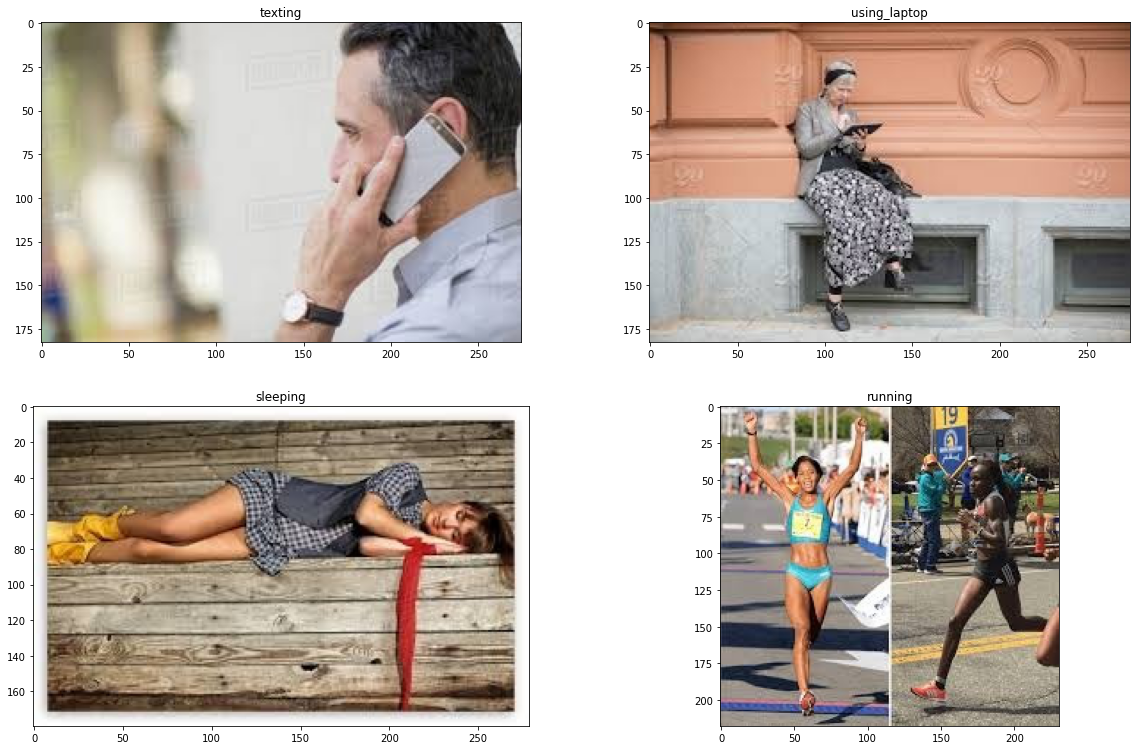

In [57]:
# Displaying 4 random images with corresponding label
displayRandom(4)

## Data Preprocessing

In [58]:
# Configure image size
IMG_HEIGHT = 224
IMG_WIDTH = 224

In [59]:
# Model training configuration
FAST = 0

EPOCH = 60

if FAST == 1:
  EPOCH = 3

In [60]:
# Label encoding and seperate dependant variable

lb = LabelBinarizer()
y = lb.fit_transform(df['label'])
classes = lb.classes_
print(classes)

['calling' 'clapping' 'cycling' 'dancing' 'drinking' 'eating' 'fighting'
 'hugging' 'laughing' 'listening_to_music' 'running' 'sitting' 'sleeping'
 'texting' 'using_laptop']


In [61]:
# Take independant variable as numpy array

x = df['filename'].values

In [62]:
# Split data as 90% of training and 10% of test data
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.1, random_state=100) 

In [63]:
print(x_train.shape, x_test.shape)

(11340,) (1260,)


In [64]:
# Load pixel data as a list of numpy arrays

img_data = []
size = len(x_train)

for i in tqdm(range(size)):
    image = Image.open('/content/Human Action Recognition/train/' + x_train[i])
    img_data.append(np.asarray(image.resize((IMG_HEIGHT,IMG_WIDTH))))

  0%|          | 0/11340 [00:00<?, ?it/s]

## Research Assignment Reporting Functions

In [65]:
def print_validation_report(test_labels, predictions):
    print("Classification Report")
    print(classification_report(test_labels, predictions))
    print('Accuracy Score: {}'.format(accuracy_score(test_labels, predictions)))
    print('Root Mean Square Error: {}'.format(np.sqrt(MSE(test_labels, predictions)))) 
    
def plot_confusion_matrix(y_true, y_pred):
    mtx = confusion_matrix(y_true, y_pred)
    fig, ax = plt.subplots(figsize=(16,12))
    sns.heatmap(mtx, annot=True, fmt='d', linewidths=.75,  cbar=False, ax=ax,cmap='Blues',linecolor='white')
    #  square=True,
    plt.ylabel('true label')
    plt.xlabel('predicted label')

def plot_history(history):
  losses = history.history['loss']
  accs = history.history['accuracy']
  val_losses = history.history['val_loss']
  val_accs = history.history['val_accuracy']
  epochs = len(losses)

  plt.figure(figsize=(16, 4))
  for i, metrics in enumerate(zip([losses, accs], [val_losses, val_accs], ['Loss', 'Accuracy'])):
    plt.subplot(1, 2, i + 1)
    plt.plot(range(epochs), metrics[0], label='Training {}'.format(metrics[2]))
    plt.plot(range(epochs), metrics[1], label='Validation {}'.format(metrics[2]))
    plt.legend()
  plt.show()

def display_training_curves(training, validation, title, subplot):
  ax = plt.subplot(subplot)
  ax.plot(training)
  ax.plot(validation)
  ax.set_title('model '+ title)
  ax.set_ylabel(title)
  ax.set_xlabel('epoch')
  ax.legend(['training', 'validation'])

## Build the CNN model


In [66]:
data_augmentation = keras.Sequential(
    [
        layers.RandomFlip("horizontal"),
        layers.RandomRotation(0.1),
        layers.RandomZoom(0.2),
    ]
)

In [67]:
k.clear_session()

conv_base  = keras.applications.vgg16.VGG16(
    weights="imagenet",
    include_top=False)
conv_base.trainable = False

#conv_base.trainable = True
#for layer in conv_base.layers[:-4]:
#    layer.trainable = False

# Creating the model 

inputs = keras.Input(shape=(IMG_HEIGHT, IMG_WIDTH, 3))
x = data_augmentation(inputs)
#x = layers.Rescaling(1./255)(x)
x = keras.applications.vgg16.preprocess_input(x)
x = conv_base(x)
x = layers.Flatten()(x)
x = layers.Dense(256)(x)
x = layers.Dropout(0.5)(x)
x = layers.Dense(64)(x)
x = layers.Dropout(0.5)(x)
outputs = layers.Dense(15, activation="softmax")(x)
model = keras.Model(inputs=inputs, outputs=outputs)

## Compile the CNN model

In [68]:
model.compile(optimizer=keras.optimizers.RMSprop(learning_rate=0.01), loss='categorical_crossentropy',metrics=['accuracy'])
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 sequential (Sequential)     (None, 224, 224, 3)       0         
                                                                 
 tf.__operators__.getitem (S  (None, 224, 224, 3)      0         
 licingOpLambda)                                                 
                                                                 
 tf.nn.bias_add (TFOpLambda)  (None, 224, 224, 3)      0         
                                                                 
 vgg16 (Functional)          (None, None, None, 512)   14714688  
                                                                 
 flatten (Flatten)           (None, 25088)             0         
                                                             

## Train the CNN model

In [69]:
%%time

# Training the model

lrr= ReduceLROnPlateau(
                       monitor='val_accuracy', #Metric to be measured
                       factor=.01, #Factor by which learning rate will be reduced
                       patience=3,  #No. of epochs after which if there is no improvement in the val_acc, the learning rate is reduced
                       min_lr=1e-5) #The minimum learning rate 

history = model.fit(np.asarray(img_data), y_train, validation_split=0.1, epochs=EPOCH,
                    callbacks=[tf.keras.callbacks.ModelCheckpoint("Assignment_4_EX2_VGG16.h5",save_best_only=True,save_weights_only=False, monitor="val_loss")])

Epoch 1/3


319/319 [==============================] - 37s 105ms/step - loss: 822.4587 - accuracy: 0.2531 - val_loss: 399.3007 - val_accuracy: 0.2875
Epoch 2/3
319/319 [==============================] - 33s 103ms/step - loss: 562.6776 - accuracy: 0.2584 - val_loss: 328.3597 - val_accuracy: 0.4533
Epoch 3/3
319/319 [==============================] - 33s 102ms/step - loss: 667.2102 - accuracy: 0.2857 - val_loss: 564.3372 - val_accuracy: 0.3871
CPU times: user 3min 44s, sys: 44.9 s, total: 4min 29s
Wall time: 1min 44s


## Plot performance metrics

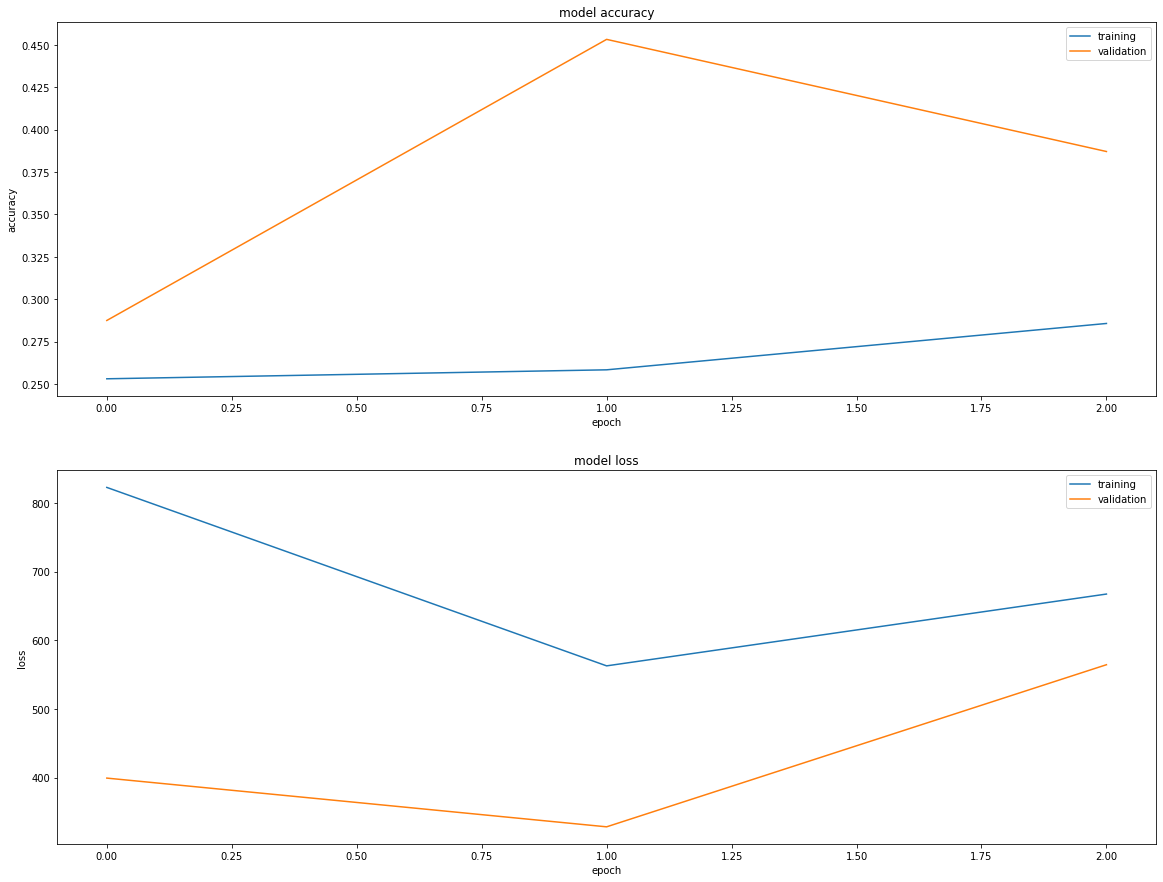

In [70]:
plt.subplots(figsize=(16,12))
plt.tight_layout()
display_training_curves(history.history['accuracy'], history.history['val_accuracy'], 'accuracy', 211)
display_training_curves(history.history['loss'], history.history['val_loss'], 'loss', 212)

In [71]:
# Model accuracy
%%time
test_img_data = []
test_img_data_scaled = []
size = len(x_test)

for i in tqdm(range(size)):
    image = Image.open('/content/Human Action Recognition/train/' + x_test[i])
    test_img_data.append(np.asarray(image.resize((IMG_HEIGHT,IMG_WIDTH))))
    test_img_data_scaled.append(np.asarray(image.resize((IMG_HEIGHT,IMG_WIDTH)))/255)

scores = model.evaluate(np.asarray(test_img_data), y_test)
print(f"Test Accuracy: {scores[1]}")

  0%|          | 0/1260 [00:00<?, ?it/s]

40/40 [==============================] - 1s 18ms/step - loss: 593.7390 - accuracy: 0.3730
Test Accuracy: 0.3730158805847168
CPU times: user 5.62 s, sys: 355 ms, total: 5.98 s
Wall time: 6.19 s


## Create the confusion matrix

In [72]:
# Get the predicted classes:
pred_classes = np.argmax(model.predict(np.asarray(test_img_data)), axis=-1)
pred_classes;

40/40 [==============================] - 1s 16ms/step


In [73]:
y_test_decoded = np.argmax(y_test, axis=-1)

In [74]:
print_validation_report(y_test_decoded,pred_classes)

Classification Report
              precision    recall  f1-score   support

           0       0.25      0.03      0.06        92
           1       0.38      0.30      0.33        84
           2       0.87      0.89      0.88        84
           3       0.61      0.52      0.56        83
           4       0.71      0.06      0.11        82
           5       0.86      0.74      0.80        86
           6       0.82      0.13      0.23        69
           7       0.20      0.67      0.31        96
           8       0.74      0.13      0.22       106
           9       0.00      0.00      0.00        88
          10       0.63      0.65      0.64        79
          11       0.27      0.26      0.26        97
          12       0.73      0.16      0.27        67
          13       0.47      0.10      0.16        70
          14       0.19      0.96      0.31        77

    accuracy                           0.37      1260
   macro avg       0.52      0.37      0.34      1260
weig

/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


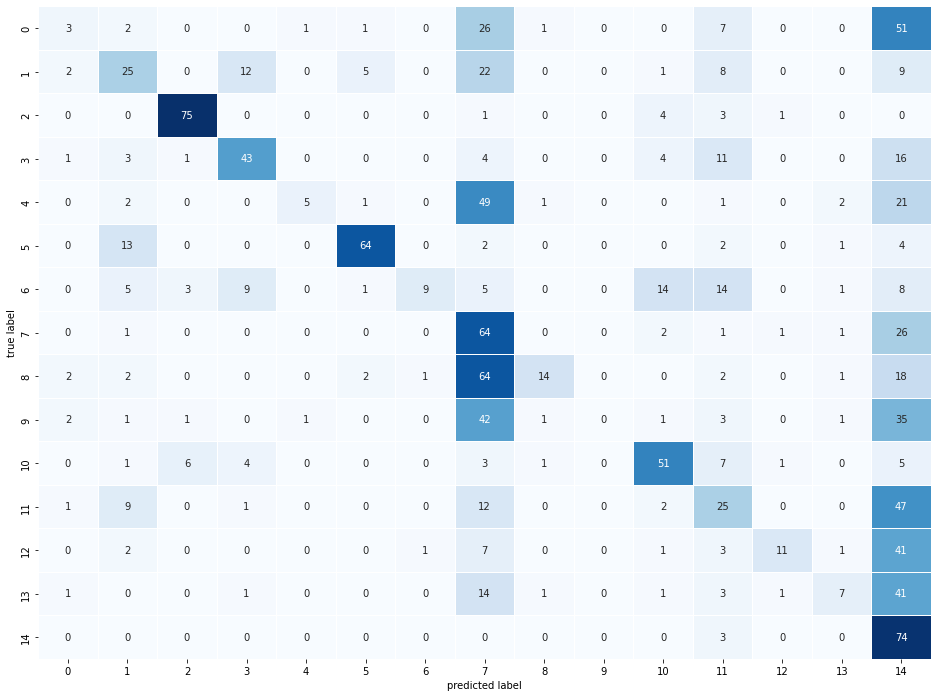

In [75]:
plot_confusion_matrix(np.argmax(y_test, axis=-1),pred_classes)

## Inspection of wrongly classified images

In [108]:
# Helper function to predict the pose of the input image 
def test_predict_wrong_classification(train_image, actual, plt):
    result = model.predict(np.asarray([read_image(train_image)]))

    itemindex = np.where(result==np.max(result))
    prediction = classes[itemindex[1][0]]
    
    predict_status = True

    if prediction != actual:
      image = img.imread(train_image)
      plt.imshow(image)
      plt.title(f'Predicted class : {prediction}\nActual class : {actual}')
      predict_status = False
  
    return predict_status

# Function to display wrongly classified human pose images
def displayWronglyClassifiedImagesRandom(n=1):
    plt.figure(figsize=(20,20))
    count = 0
    while count < n:
        rnd = random.randint(0,len(df)-1)
        img_file = '/content/Human Action Recognition/train/' + df['filename'][rnd]
        if os.path.exists(img_file):
            plt.subplot(n//2+1, 2, count + 1)

            if test_predict_wrong_classification(img_file,df['label'][rnd],plt) == False:
              count += 1

1/1 [==============================] - 0s 21ms/step


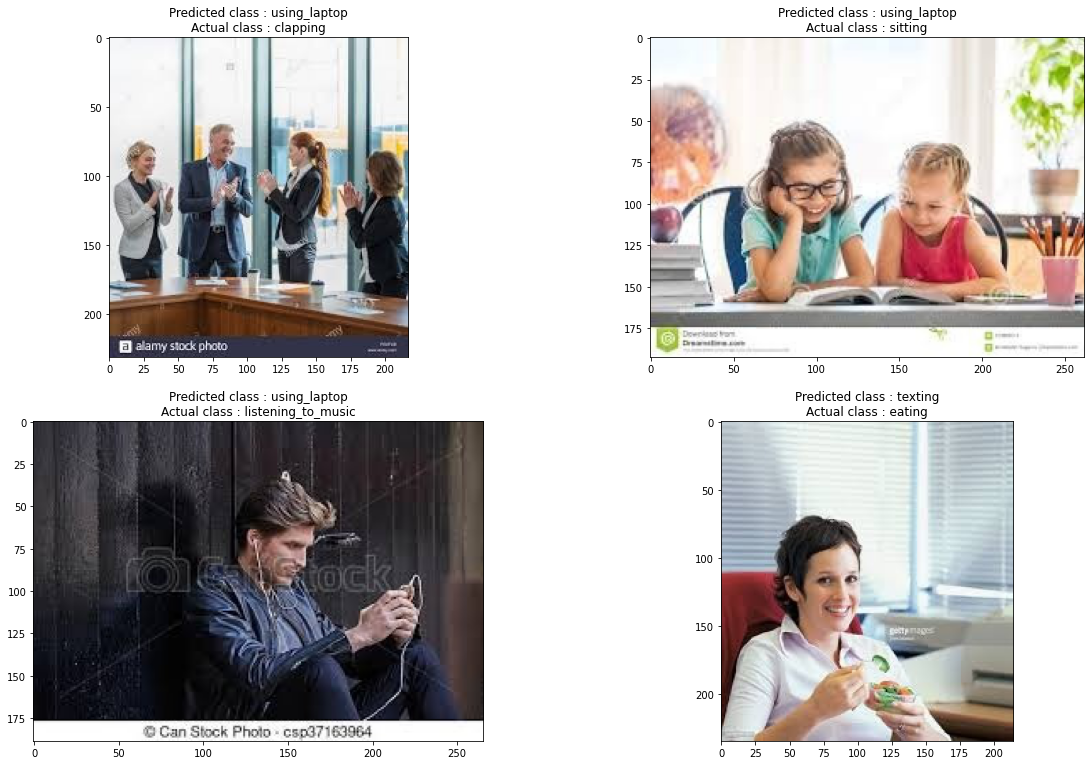

In [109]:
# Display first four wrongly classified human poses
displayWronglyClassifiedImagesRandom(4)

## Making Predictions

In [76]:
# Function to read images as array

def read_image(fn):
    image = Image.open(fn)
    return np.asarray(image.resize((IMG_HEIGHT,IMG_WIDTH)))

In [77]:
# Function to predict

def test_predict(test_image):
    result = model.predict(np.asarray([read_image(test_image)]))

    itemindex = np.where(result==np.max(result))
    prediction = classes[itemindex[1][0]]
    print("probability: "+str(np.max(result)*100) + "%\nPredicted class : ", prediction)

    image = img.imread(test_image)
    plt.imshow(image)
    plt.title(prediction)

1/1 [==============================] - 0s 24ms/step
probability: 100.0%
Predicted class :  running


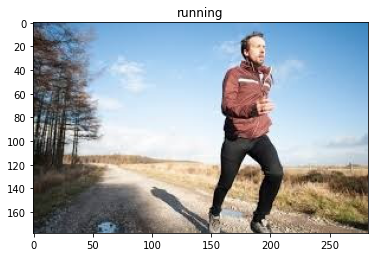

In [78]:
test_predict('/content/Human Action Recognition/test/Image_100.jpg')

1/1 [==============================] - 0s 24ms/step
probability: 100.0%
Predicted class :  texting


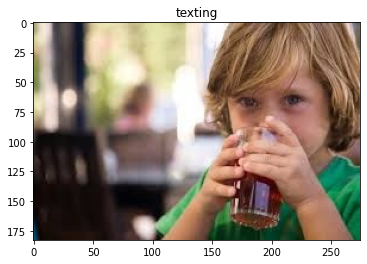

In [79]:
test_predict('/content/Human Action Recognition/test/Image_10.jpg')

1/1 [==============================] - 0s 23ms/step
probability: 100.0%
Predicted class :  hugging


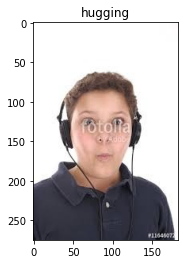

In [80]:
test_predict('/content/Human Action Recognition/test/Image_11.jpg')

1/1 [==============================] - 0s 25ms/step
probability: 100.0%
Predicted class :  clapping


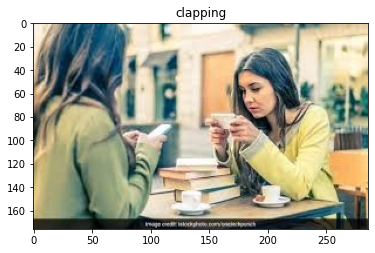

In [81]:
test_predict('/content/Human Action Recognition/test/Image_1024.jpg')

1/1 [==============================] - 0s 25ms/step
probability: 100.0%
Predicted class :  hugging


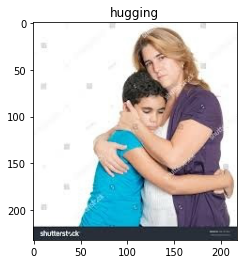

In [82]:
test_predict('/content/Human Action Recognition/test/Image_640.jpg')